# Data Preparation for Seq2Seq model

This notebook was mainly digested from https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full_Exog.ipynb.







1. Data Source:
We'll be using the same daily wikipedia web page traffic dataset, available here on [Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data). 

In order to make the progress quick, I digested part data  into https://MrYingLee.Github.io/Seq2Seq/train_1.csv .

2. I only add the last part, **4. Saving Data**

## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('https://MrYingLee.Github.io/Seq2Seq/train_1.csv') 
df.head()

,Page,2015/7/1,2015/7/2,2015/7/3,2015/7/4,2015/7/5,2015/7/6,2015/7/7,2015/7/8,2015/7/9,2015/7/10,2015/7/11,2015/7/12,2015/7/13,2015/7/14,2015/7/15,2015/7/16,2015/7/17,2015/7/18,2015/7/19,2015/7/20,2015/7/21,2015/7/22,2015/7/23,2015/7/24,2015/7/25,2015/7/26,2015/7/27,2015/7/28,2015/7/29,2015/7/30,2015/7/31,2015/8/1,2015/8/2,2015/8/3,2015/8/4,2015/8/5,2015/8/6,2015/8/7,2015/8/8,...,2016/11/22,2016/11/23,2016/11/24,2016/11/25,2016/11/26,2016/11/27,2016/11/28,2016/11/29,2016/11/30,2016/12/1,2016/12/2,2016/12/3,2016/12/4,2016/12/5,2016/12/6,2016/12/7,2016/12/8,2016/12/9,2016/12/10,2016/12/11,2016/12/12,2016/12/13,2016/12/14,2016/12/15,2016/12/16,2016/12/17,2016/12/18,2016/12/19,2016/12/20,2016/12/21,2016/12/22,2016/12/23,2016/12/24,2016/12/25,2016/12/26,2016/12/27,2016/12/28,2016/12/29,2016/12/30,2016/12/31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24,14,11,204,14,45,33,28,18,14,47,15,14,18,20,14,16,14,20,60,22,15,17,19,18,21,21,47,65,17,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14,15,15,11,20,13,19,621,57,17,23,19,21,47,28,22,22,65,27,17,17,13,9,18,22,17,15,22,23,19,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9,3,5,4,0,1,4,5,8,8,1,1,2,5,3,3,3,7,3,9,8,3,210,5,4,6,2,2,4,3,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7,10,7,10,14,17,11,9,11,5,10,8,17,13,23,40,16,17,41,17,8,9,18,12,12,18,13,18,23,10,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14,13,15,14,16,9,178,64,12,10,11,6,8,7,9,8,5,11,8,4,15,5,8,8,6,7,15,4,11,7,48,9,25,13,3,11,27,13,36,10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Columns: 551 entries, Page to 2016/12/31
dtypes: float64(365), int64(185), object(1)
memory usage: 56.1+ KB


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015/7/1 to 2016/12/31


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

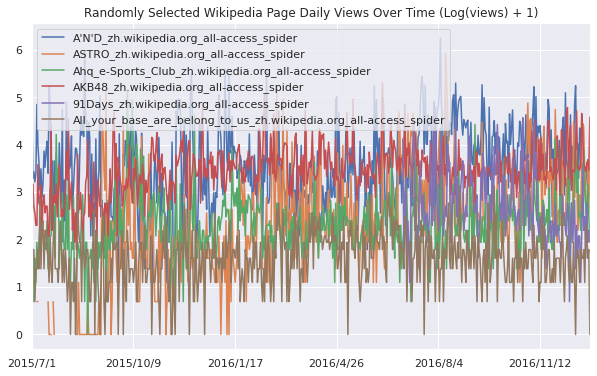

In [5]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

## 2. Exogenous Feature Engineering

Glancing back at our preview of the data above, we see that we have information that isn't directly captured by the raw traffic time series. The **page column** gives us metadata on each series that might guide our model in identifying shared patterns across related series. For example, pages written in the same language may exhibit similar seasonality patterns. Similarly, the **date column headers** let us explicitly encode day of the week information as a way of anchoring the model's understanding of weekly seasonality. In the code to follow, we'll extract numeric features from both of these sources and wrangle them into a format that keras will cleanly accept as input when combined with the raw series.



![architecture](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/Page_exog.png?raw=1)



Let's start by converting dates to **one-hot-encoded** / **dummy variable** representations of day of the week, following the standard approach for handling categorical features. It's simple to do this using pandas:  

In [6]:
dow_ohe = pd.get_dummies(pd.to_datetime(df.columns[1:]).dayofweek)
dow_ohe.head(8)

,0,1,2,3,4,5,6
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0
6,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0


Right now we have a dataframe of shape (n_timesteps, 7), with binary columns corresponding to each day of the week. We need to do a bit more for keras-friendly formatting: when processing a sequence of features, keras expects input arrays (tensors) of shape **(n_samples, n_timesteps, n_features)**. In this case, the day of week features are shared across all of the individual page series (our samples), so we want to just repeat the one-hot-encoded data n_samples (~145,000) times to get the 3-dimensional array we need. We can accomplish this using the handy numpy functions **expand_dims** and **tile** as below.

In [7]:
dow_array = np.expand_dims(dow_ohe.values, axis=0) # add sample dimension
dow_array = np.tile(dow_array,(df.shape[0],1,1)) # repeat OHE array along sample dimension
dow_array.shape

(13, 550, 7)

Great, that's the exact format we need for an input array; now we'll just add the **page metadata** to this array. Let's take a quick look at the raw format of that metadata:

In [8]:
df['Page'].head(8)

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5              5566_zh.wikipedia.org_all-access_spider
6            91Days_zh.wikipedia.org_all-access_spider
7             A'N'D_zh.wikipedia.org_all-access_spider
Name: Page, dtype: object

It turns out that this data is underscore delimited as **name_project_access_agent**. We should split that out into distinct columns, with the one tricky part being that underscores can occur in the _name_ field that would throw off a simple split on underscore. A quick workaround is to use the **rsplit** function to work from right to left and limit the number of splits to 3. 

In [9]:
page_df = df['Page'].str.rsplit('_', n=3, expand=True) # split page string and expand to multiple columns 
page_df.columns = ['name','project','access','agent']
page_df.head()

,name,project,access,agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


That looks great, so let's do a quick cardinality check on each of these categorical variables before we one-hot-encode them like we did for day of the week.

In [10]:
page_df.nunique()

name       13
project     1
access      1
agent       1
dtype: int64

Since there are so many different names, it's likely more trouble than it's worth to include name in our feature set (it would mean an increase of ~50000 features in our input array!). So we'll drop name and one-hot-encode the low cardinality features to get a dataframe of shape (n_samples, n_features). Then we can repeat these features along the timesteps dimension to get the needed 3-dimensional array.      

In [11]:
page_df = page_df.drop('name', axis=1)

page_array = pd.get_dummies(page_df).values
page_array = np.expand_dims(page_array, axis=1) # add timesteps dimension
page_array = np.tile(page_array,(1,dow_array.shape[1],1)) # repeat OHE array along timesteps dimension 
page_array.shape

(13, 550, 3)

The final step to complete our exogenous feature array is simply to concatenate the day of week information and page metadata into one shared array.

In [12]:
exog_array = np.concatenate([dow_array, page_array], axis=-1)
exog_array.shape

(13, 550, 10)

That's it, our exogenous feature extraction is all done! In the next section we'll write a function that lets us combine this exogenous feature array with the endogenous time series data in order to prepare for model training and prediction.   

## 3. Formatting the Data for Modeling 

Sadly we can't just throw the time series dataframe and exogenous array we've created into keras and let it work its magic. Instead, we have to set up a few more data transformation steps to extract the exact numpy arrays that we'll later pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and prediction intervals for the purposes of training and validation. Note that for our simple convolutional model we won't use an encoder-decoder architecture like in the first notebook in this repo, but **we'll keep the "encoding" and "decoding" (prediction) terminology to be consistent** -- in this case, the encoding interval represents the entire series history that we will use for the network's feature learning, but not output any predictions on. 

We'll use a style of **walk-forward validation**, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 60 days). This way, we simulate how our model will perform on unseen data that comes in the future. 

[Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) has created a very nice image that visualizes this validation style and contrasts it with traditional validation. I highly recommend checking out his entire repo, as he's implemented a truly state of the art (and competition winning) seq2seq model on this data set. 

![architecture](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/images/ArturSuilin_validation.png?raw=1)

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 60 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 60 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [0]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [0]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [15]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-09-02 00:00:00
Train prediction: 2016-09-03 00:00:00 - 2016-11-01 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2016-11-01 00:00:00
Val prediction: 2016-11-02 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 430
Prediction interval: 60


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 
* Create final function to extract complete encoding and target arrays, leveraging prior functions 
    - This will act as a one-shot function that grabs what we need to train or predict
    - It will extract (transformed) endogenous series data and combine it with our exogenous features

The first code block below accomplishes the first 3 steps, unchanged from the earlier notebooks in this series.

In [0]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

Now we can leverage the first 3 processing steps built out above in order to create a one-shot preprocessing function for extracting encoder/input data (with the correct exogenous features attached) and decoder/target data. We'll include arguments that let us choose the number of time series samples to extract and which periods to sample from. With this function written, we'll be ready to set up the model!      

In [0]:
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data

In [0]:
first_n_samples = df.shape[0]
encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                           train_enc_start, train_enc_end, train_pred_start, train_pred_end)

## 4. Saving Data

This is the only part I added by myself.

In [0]:
encoder_input_file="encoder_input.npy"
decoder_target_file="decoder_target.npy"

In [0]:
np.save(encoder_input_file, encoder_input_data)
np.save(decoder_target_file, decoder_target_data)

In [21]:
encoder_input_data.shape

(13, 489, 11)

In [22]:
encoder_input_data[0,0,:]

array([0.11255579, 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        ])

In [23]:
decoder_target_data.shape

(13, 60, 1)

In [24]:
decoder_target_data[0,:,:]

array([[ 4.26213344e-01],
       [ 1.63849080e-01],
       [ 3.46170637e-01],
       [ 1.12555785e-01],
       [ 1.63849080e-01],
       [ 1.12555785e-01],
       [ 1.19346850e+00],
       [ 1.33015029e-03],
       [ 1.35777155e+00],
       [-3.46976544e-01],
       [-3.46976544e-01],
       [-1.92825864e-01],
       [ 2.12639244e-01],
       [ 2.59159260e-01],
       [-1.92825864e-01],
       [ 3.86992631e-01],
       [ 2.12639244e-01],
       [-1.92825864e-01],
       [ 6.64624368e-01],
       [ 1.33015029e-03],
       [-4.33987921e-01],
       [-1.92825864e-01],
       [ 9.74779296e-01],
       [ 5.84885641e-02],
       [-1.92825864e-01],
       [ 1.45857625e+00],
       [ 8.81688873e-01],
       [ 1.63849080e-01],
       [-1.23832993e-01],
       [-1.92825864e-01],
       [-2.66933836e-01],
       [-1.23832993e-01],
       [-4.33987921e-01],
       [ 4.63953672e-01],
       [-1.92825864e-01],
       [ 3.03611022e-01],
       [-1.23832993e-01],
       [ 3.46170637e-01],
       [-2.6

In [0]:
from google.colab import files

files.download(encoder_input_file)
files.download(decoder_target_file)